---------------------------------------------------------------------------------------------------

In [2]:
from qiskit import QuantumCircuit
from qiskit import transpile
from qiskit.primitives import StatevectorSampler
from qiskit_ibm_runtime import QiskitRuntimeService, SamplerV2 as Sampler
from qiskit.visualization import plot_histogram, circuit_drawer

from collections import Counter
import csv
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from matplotlib.ticker import AutoMinorLocator, NullLocator
from qiskit.quantum_info import Statevector, DensityMatrix, partial_trace, entropy

from qiskit_experiments.library.tomography import StateTomography


python -m venv venv
venv\Scripts\activate
pip install qiskit notebook ipykernel
python -m ipykernel install --user --name=venv --display-name "Python (Qiskit)"


In [2]:
%matplotlib inline

---------------------------------------------------------------------------------------------------------------

## $\textbf{Algoritmo de Deutsch}$

Implementar los 4 oráculos posibles 
- $f(0) = 1$, $f(1)= 0$ el oráculo en este caso es un CNOT al que luego se le aplica X
- $f(0) = 0$, $f(1)= 1$ el oráculo en este caso es un CNOT 
- $f(0) = 0$, $f(1)= 0$ el oráculo en este caso no es nada o pues es I
- $f(0) = 1$, $f(1)= 1$ el oráculo en este caso es un X aplicado al qbit target

In [3]:
def oracle_cx(quantumCircuit):
    quantumCircuit.cx(0,1)
    quantumCircuit.x(1)

def oracle_c(quantumCircuit):
    quantumCircuit.cx(0, 1)
    
def oracle_0(quantumCircuit):
    quantumCircuit.id(0)
    
def oracle_1(quantumCircuit):
    quantumCircuit.x(1)

In [4]:
def Deutsch(oracle):
    """Crea un circuito cuantico con 2 qbits y un bit clasico, establece el estado en |0⟩|1⟩, aplica una compuerta Hadamard a cada uno, se pasa el estado por un oráculo, despúes se aplica una compurta Hadamard al qbit control y se mide. 

    Args:
        oracle (_func_): _description_f
    """
    
    quantumCircuit = QuantumCircuit(2, 1) 
    
    quantumCircuit.id(0)
    quantumCircuit.x(1)
    
    quantumCircuit.h(0)
    quantumCircuit.h(1)
    
    quantumCircuit.barrier()
    
    oracle(quantumCircuit)
    
    quantumCircuit.barrier()
    
    quantumCircuit.h(0)
    
    quantumCircuit.measure(0, 0)
    
    return quantumCircuit

--------------------------------------------------------------------------------------------------------------

### $\textbf{Dibujo de oráculos}$

In [ ]:
oraculos = [oracle_0, oracle_1, oracle_c, oracle_cx]
nombres_oraculos = [r'Circuito para la función constante $f(0)=0, \; f(1) = 0$',
           r'Circuito para la función constante $f(0)=1, \; f(1) = 1$',
           r'Circuito para la función balanceada $f(0)=0, \; f(1) = 1$',
           r'Circuito para la función balanceada $f(0)=1, \; f(1) = 0$']

nombres_imagenes = ['cte1', 'cte2', 'bal1', 'bal2' ]

for oracle_func, nombre, n1 in zip(oraculos, nombres_oraculos, nombres_imagenes):

    qc = Deutsch(oracle_func)

    fig, ax = plt.subplots(figsize=(8, 4))
    
    qc.draw('mpl', ax=ax)

    fig.suptitle(nombre, fontsize=16, y=0.98)  

    fig.subplots_adjust(top=0.85, bottom=0.2)  

    plt.show()

    fig.savefig(n1+'.png', dpi=300, bbox_inches='tight')

---------------------------------------------------------------------------------------------------------------

### $\textbf{Device IBM}$

In [ ]:
def guardar_resultados_deutsch(result, nombre_archivo):
    
    all_counts = []
    all_bitstrings = set()

    for i, pub_result in enumerate(result):
        bits = [''.join(str(bit) for bit in b) for b in pub_result.data.c.array]
        counts = Counter(bits)
        all_counts.append((f"circuito_{i+1}", counts))
        all_bitstrings.update(counts.keys())

    bit_columns = sorted(all_bitstrings)

    with open(nombre_archivo, "w", newline="") as f:
        writer = csv.writer(f)
        writer.writerow(["nombre_circuito"] + bit_columns)
        for nombre, counts in all_counts:
            row = [nombre] + [counts.get(b, 0) for b in bit_columns]
            writer.writerow(row)

In [ ]:
QiskitRuntimeService.save_account(token='6b4228aab7b53fba472c23700c2606646493afddb2c554cd6c4036271593303da2b212c0885c7c9b0bf5b0c8636168235e50418f0c57f5ee2bfb59c4510a47e2', channel='ibm_quantum', overwrite=True)

service = QiskitRuntimeService()

backend = service.least_busy(operational=True, simulator=False)

circuito_cx = Deutsch(oracle_cx) 
circuito_c = Deutsch(oracle_c)
circuito_0 = Deutsch(oracle_0)
circuito_1 = Deutsch(oracle_1)

circuitos_transpilados = transpile([circuito_cx, circuito_c, circuito_0, circuito_1], backend=backend)

sampler = Sampler(mode=backend)

job = sampler.run(circuitos_transpilados)

result = job.result()

guardar_resultados_deutsch(result, 'resultados_deutsch.csv')

In [ ]:
from qiskit_ibm_runtime import QiskitRuntimeService
service = QiskitRuntimeService()
print(service.active_account()['instance'])

In [ ]:
QiskitRuntimeService.save_account(token='6b4228aab7b53fba472c23700c2606646493afddb2c554cd6c4036271593303da2b212c0885c7c9b0bf5b0c8636168235e50418f0c57f5ee2bfb59c4510a47e2', channel='ibm_quantum', overwrite=True)

service = QiskitRuntimeService()
backend = service.least_busy(operational=True, simulator=False)

circuitos = [
    ("oracle_cx", Deutsch(oracle_cx)),
    ("oracle_c", Deutsch(oracle_c)),
    ("oracle_0", Deutsch(oracle_0)),
    ("oracle_1", Deutsch(oracle_1)),
]

resultados = []

for nombre, circuito in circuitos:
    print(f"Ejecutando tomografía para: {nombre}")

    tomo = StateTomography(circuito)
    job = tomo.run(backend=backend, shots=8192)
    result = job.block_for_results()
    rho = result.analysis_results("state").value
    
    rho_A = partial_trace(rho, [1])
    rho_B = partial_trace(rho, [0])
    S_A = entropy(rho_A)
    S_B = entropy(rho_B)

    pureza = DensityMatrix(rho).purity()
    entangled = (pureza > 0.99) and (S_A > 0.1 or S_B > 0.1)

    resultados.append({
        "oracle": nombre,
        "entropy_q0": S_A,
        "entropy_q1": S_B,
        "purity": pureza,
        "entangled": entangled,
        'rho': rho})


df = pd.DataFrame(resultados)
df.to_csv("resultados_tomografia_deutsch_prueba2.csv", index=False)

In [ ]:
import numpy as np
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit_experiments.library.tomography import StateTomography
from qiskit.quantum_info import DensityMatrix
import pandas as pd


def partial_transpose_2qubit(rho, qubit=1):
    rho = rho.data if isinstance(rho, DensityMatrix) else rho
    rho_reshaped = rho.reshape(2, 2, 2, 2)
    
    if qubit == 0:
        
        rho_pt = np.transpose(rho_reshaped, (1, 0, 2, 3))
    elif qubit == 1:
        
        rho_pt = np.transpose(rho_reshaped, (0, 1, 3, 2))
    else:
        raise ValueError("Solo soportado qubit=0 o 1")
        
    return rho_pt.reshape(4, 4)


service = QiskitRuntimeService()
backend = service.least_busy(operational=True, simulator=False)

circuitos = [
    ("oracle_cx", Deutsch(oracle_cx)),
    ("oracle_c", Deutsch(oracle_c)),
    ("oracle_0", Deutsch(oracle_0)),
    ("oracle_1", Deutsch(oracle_1)),
]

resultados = []

for nombre, circuito in circuitos:
    print(f"Ejecutando tomografía y PPT para: {nombre}")
    tomo = StateTomography(circuito)
    job = tomo.run(backend=backend, shots=8192)
    result = job.block_for_results()

    rho = result.analysis_results("state").value
    dm = DensityMatrix(rho)

    
    rho_pt = partial_transpose_2qubit(dm, qubit=1)

 
    eigenvals = np.linalg.eigvalsh(rho_pt)
    print(nombre, eigenvals)
    min_ev = np.min(eigenvals)
    negativity = np.sum(np.abs(eigenvals[eigenvals < 0]))
    is_entangled = min_ev < -1e-6

    resultados.append({
        "oracle": nombre,
        "min_eigenvalue_PPT": min_ev,
        "negativity": negativity,
        "entangled_PPT": is_entangled
    })


df = pd.DataFrame(resultados)
df.to_csv("resultados_PPT_negatividad_deutsch.csv", index=False)
print("Resultados guardados en 'resultados_PPT_negatividad_deutsch.csv'")


In [5]:
import pandas as pd
df = pd.read_csv("resultados_deutsch.csv")

estados = df.columns[1:]

real_counts_list = []
for _, fila in df.iterrows():
    counts = Counter({estado: int(fila[estado]) for estado in estados})
    real_counts_list.append(counts)

nombres = df["nombre_circuito"].tolist()

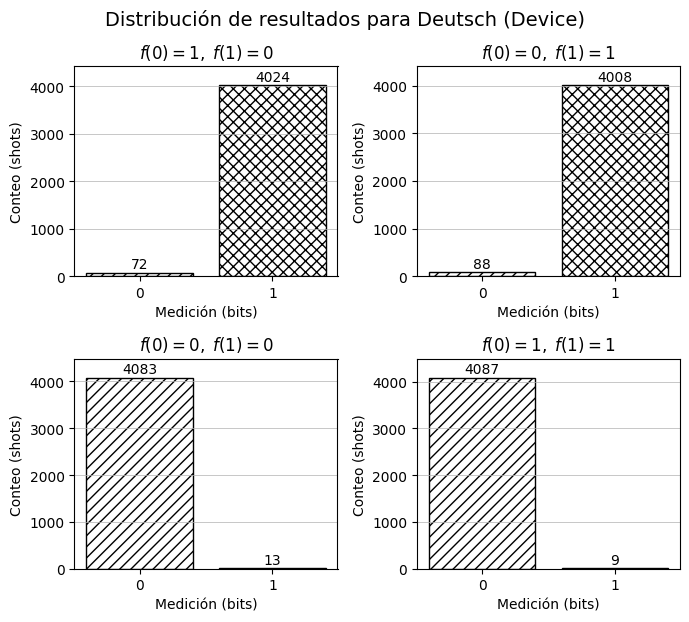

In [6]:

labels = [r'$f(0)=1, \; f(1) = 0$', r'$f(0) = 0, \; f(1) = 1$', r'$f(0)=0, \; f(1) = 0$', r'$f(0)=1, \; f(1) = 1$']
hatch_map = {'0': '///', '1': 'xxx'}  

fig, axs = plt.subplots(2, 2, figsize=(7, 6))
axs = axs.flatten()

for i in range(4):
    counts = real_counts_list[i]
    ax = axs[i]

    keys = sorted(counts.keys())
    values = [counts[k] for k in keys]

    bars = []
    for j, k in enumerate(keys):
        bar = ax.bar(k, values[j], color='white', edgecolor='black', hatch=hatch_map[k])
        bars.append(bar)

    ax.set_title(labels[i])
    ax.set_ylim(0, max(values) + 400)
    ax.set_ylabel('Conteo (shots)')
    ax.set_xlabel('Medición (bits)')
    ax.grid(True, which='major', axis='y', linestyle='-', linewidth=0.5)

    for j, bar in enumerate(bars):
        height = values[j]
        ax.text(
            keys[j], height + 30, str(height),
            ha='center', va='bottom', fontsize=10
        )

plt.tight_layout()
plt.suptitle('Distribución de resultados para Deutsch (Device)', fontsize=14, y=1.03)
plt.savefig('deutsch_device.png', dpi=300, bbox_inches='tight')
plt.show()


---------------------------------------------------------------------------------------------------------------


### $\textbf{Simulaciones}$

In [7]:
circuito_cx = Deutsch(oracle_cx)
circuito_c = Deutsch(oracle_c)
circuito_0 = Deutsch(oracle_0)
circuito_1 = Deutsch(oracle_1)

sampler = StatevectorSampler()

job = sampler.run([circuito_cx, circuito_c, circuito_0, circuito_1], shots=4096)
sim_result = job.result()

sim_counts_list = []
estados_deseados = ['0', '1']  

for pub_result in sim_result:
    bits = [''.join(str(bit) for bit in b) for b in pub_result.data.c.array]
    counts = Counter(bits)

    for estado in estados_deseados:
        if estado not in counts:
            counts[estado] = 0

    sim_counts_list.append(counts)

In [ ]:
sim_counts_list

[Counter({'1': 4096, '0': 0}),
 Counter({'1': 4096, '0': 0}),
 Counter({'0': 4096, '1': 0}),
 Counter({'0': 4096, '1': 0})]

In [ ]:
labels = [r'$f(0)=1, \; f(1) = 0$', r'$f(0) = 0, \; f(1) = 1$', r'$f(0)=0, \; f(1) = 0$', r'$f(0)=1, \; f(1) = 1$']

fig, axs = plt.subplots(2, 2, figsize=(7, 6))
axs = axs.flatten()

for i in range(4):
    counts = sim_counts_list[i]
    ax = axs[i]

    keys = sorted(counts.keys())
    values = [counts[k] for k in keys]
    
    color_map = {'0': "#085389", '1': "#da7821"}
    colors = [color_map[k] for k in keys]

    bars = ax.bar(keys, values, color=colors)
    ax.set_title(labels[i])
    
    max_height = max(values) + 400
    ax.set_ylim(0, max_height)
    ax.set_ylabel('Conteo (shots)')
    ax.set_xlabel('Medición (bits)')
    
    for bar in bars:
        height = bar.get_height()
        ax.text(
            bar.get_x() + bar.get_width() / 2.0,
            height + 30, 
            str(int(height)),
            ha='center', va='bottom',
            color='black', fontsize=10
            
        )
    
    ax.grid(True, which='major', axis='y', linestyle='--', linewidth=0.5)

plt.tight_layout()
plt.suptitle('Distribución de resultados para Deutsch', fontsize=14, y=1.03)
plt.savefig('deutsch_sim.png', dpi=300, bbox_inches='tight')
plt.show()


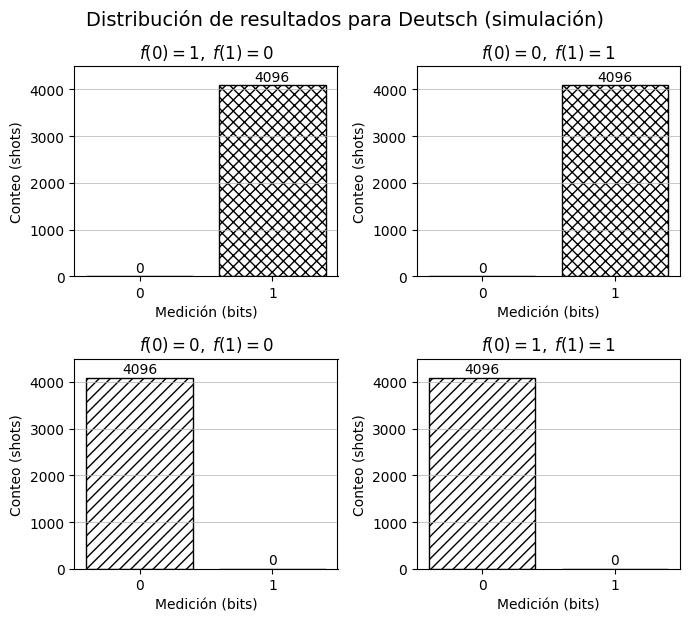

In [8]:

labels = [r'$f(0)=1, \; f(1) = 0$', r'$f(0) = 0, \; f(1) = 1$', r'$f(0)=0, \; f(1) = 0$', r'$f(0)=1, \; f(1) = 1$']
hatch_map = {'0': '///', '1': 'xxx'}  

fig, axs = plt.subplots(2, 2, figsize=(7, 6))
axs = axs.flatten()

for i in range(4):
    counts = sim_counts_list[i]
    ax = axs[i]

    keys = sorted(counts.keys())
    values = [counts[k] for k in keys]

    bars = []
    for j, k in enumerate(keys):
        bar = ax.bar(k, values[j], color='white', edgecolor='black', hatch=hatch_map[k])
        bars.append(bar)

    ax.set_title(labels[i])
    ax.set_ylim(0, max(values) + 400)
    ax.set_ylabel('Conteo (shots)')
    ax.set_xlabel('Medición (bits)')
    ax.grid(True, which='major', axis='y', linestyle='-', linewidth=0.5)

    for j, bar in enumerate(bars):
        height = values[j]
        ax.text(
            keys[j], height + 30, str(height),
            ha='center', va='bottom', fontsize=10
        )

plt.tight_layout()
plt.suptitle('Distribución de resultados para Deutsch (simulación)', fontsize=14, y=1.03)
plt.savefig('deutsch_sim.png', dpi=300, bbox_inches='tight')
plt.show()


---------------------------------------------------------------------------------------------------------------


### $\textbf{Criterio de Pureza - sim}$

In [ ]:
def entrelazamiento_Deutsch(circuito):
    
    circuito_sinMedicion = circuito.remove_final_measurements(inplace=False)

    estadoCuantico = Statevector.from_instruction(circuito_sinMedicion)

    matriz_densidad = DensityMatrix(estadoCuantico)
    
    rho = matriz_densidad.data
    traza_matriz_densidad = np.trace(rho @ rho).real    
    
    if traza_matriz_densidad > 0.9:
        
        matriz_densidad_reducida = partial_trace(matriz_densidad, [1]).data

        pureza = (matriz_densidad_reducida @ matriz_densidad_reducida).trace().real
    
        return pureza
        
    else:
        print('No se puede afirmar nada sobre el entrelazamiento en el estado.')

In [ ]:
c_0 = 'Función constante  f(0) = 0, f(1) = 0 | Pureza: ' + str(entrelazamiento_Deutsch(circuito_0))
c_1 = 'Función constante  f(0) = 1, f(1) = 1 | Pureza: ' + str(entrelazamiento_Deutsch(circuito_1))
c_cx = 'Función balanceada f(0) = 1, f(1) = 0 | Pureza: ' + str(entrelazamiento_Deutsch(circuito_cx))
c_x = 'Función balanceada f(0) = 0, f(1) = 1 | Pureza: ' + str(entrelazamiento_Deutsch(circuito_c))


print(c_0)
print(c_1)
print(c_cx)
print(c_x)

Función constante  f(0) = 0, f(1) = 0 | Pureza: 0.9999999999999991
Función constante  f(0) = 1, f(1) = 1 | Pureza: 0.9999999999999991
Función balanceada f(0) = 1, f(1) = 0 | Pureza: 0.9999999999999991
Función balanceada f(0) = 0, f(1) = 1 | Pureza: 0.9999999999999991


In [ ]:
sim_counts_list

[Counter({'1': 4096, '0': 0}),
 Counter({'1': 4096, '0': 0}),
 Counter({'0': 4096, '1': 0}),
 Counter({'0': 4096, '1': 0})]

---------------------------------------------------------------------------------------------------------------

### $\textbf{Gráficas comparativas}$

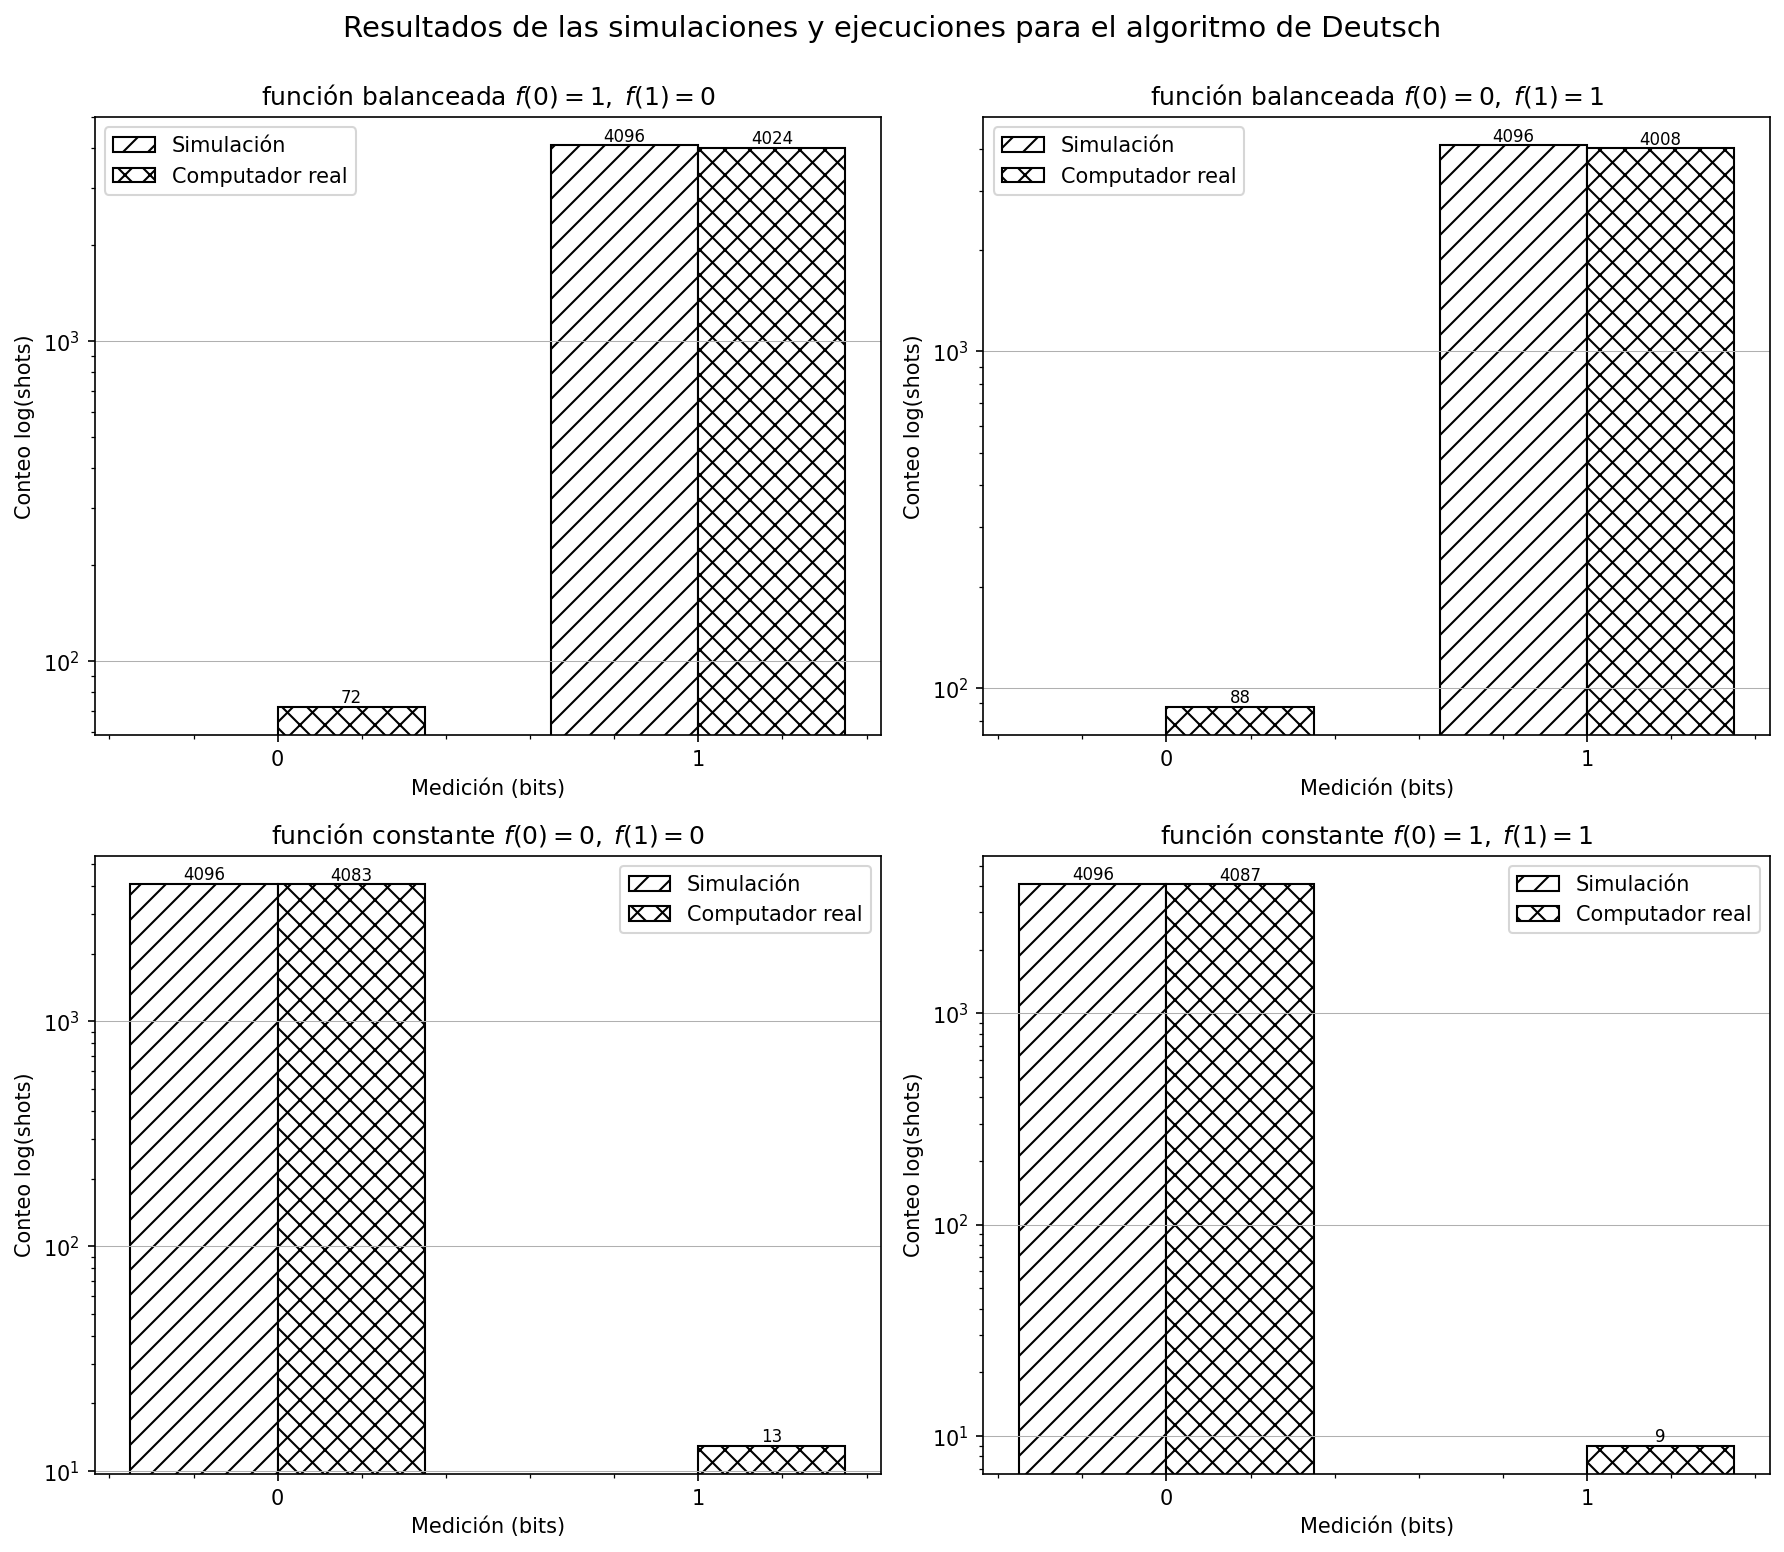

In [16]:
estados_deseados = ['0', '1'] 
num_datasets = 2              
bar_width = 0.35   

fig, axs = plt.subplots(2, 2, figsize=(12, 10), dpi = 150)

nombres = [r'función balanceada $f(0)=1, \; f(1) = 0$',
           r'función balanceada $f(0)=0, \; f(1) = 1$',
           r'función constante $f(0)=0, \; f(1) = 0$',
           r'función constante $f(0)=1, \; f(1) = 1$']

for i in range(4):
    ax = axs[i // 2, i % 2]
    
    sim_data = sim_counts_list[i]
    real_data = real_counts_list[i]
    
    estados = list(estados_deseados)
    num_estados = len(estados)
    
    bar_width = 0.35
    x = range(num_estados)
    
    bars_sim = ax.bar(
        [pos - bar_width/2 for pos in x],
        [sim_data.get(state, 0) for state in estados],
        width=bar_width,
        label='Simulación',
        color='white',
        edgecolor='black',
        hatch='//'
    )
    
    bars_real = ax.bar(
        [pos + bar_width/2 for pos in x],
        [real_data.get(state, 0) for state in estados],
        width=bar_width,
        label='Computador real',
        color='white',
        edgecolor='black',
        hatch='xx'
    )
    
    for bars in [bars_sim, bars_real]:
        for bar in bars:
            height = bar.get_height()
            if height > 0:
                ax.text(
                    bar.get_x() + bar.get_width() / 2,
                    height,
                    f'{int(height)}',
                    ha='center',
                    va='bottom',
                    fontsize=8
                )
    ax.set_yscale('log')
    ax.yaxis.set_minor_locator(AutoMinorLocator())
    ax.xaxis.set_minor_locator(NullLocator())
    
    ax.set_title(nombres[i])
    ax.set_xlabel('Medición (bits)')
    ax.set_ylabel('Conteo log(shots)')
    ax.set_xticks(x)
    ax.set_xticklabels(estados, rotation=0)
    ax.minorticks_on()
    ax.grid(True, which='major', axis='y', linestyle='-', linewidth=0.5)
    ax.legend()

plt.tight_layout()
plt.suptitle('Resultados de las simulaciones y ejecuciones para el algoritmo de Deutsch', fontsize=14, y=1.03)
plt.savefig('deutsch_log.png', dpi=300, bbox_inches='tight')
plt.show()
